# Algerian Forest Fire Prediction Regression

**Abstract**

- The goal of this project is to predict the Fire Weather Index (FWI), which basically acts like a fire risk indicator, using weather and environmental data. 

- This is an individual project, and I will be using linear regression and regularization techniques (like Ridge and Lasso) to model how things like temperature, humidity, wind, and drought conditions affect FWI. 

- The idea is to build a reliable model that can help flag high-risk fire days based on patterns seen in Algerian forest fire data.

## 1. Data Cleaning and Preprocessing

### Import libraries

In [1]:
! pip install seaborn

In [2]:
! pip install statsmodels

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from numpy import log1p

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

### Load dataset

In [4]:
file_path = "/kaggle/input/uci-algerian-forest-fires/Algerian_forest_fires_cleaned.csv"

try:
    df = pd.read_csv(file_path)
    print("File loaded from: ", file_path)
except FileNotFoundError:
    print("File is not found under: ", file_path)
except Exception as e:
    print("An expected error occurred: ", e)

File loaded from:  /kaggle/input/uci-algerian-forest-fires/Algerian_forest_fires_cleaned.csv


### EDA

From online research, I came to understand the dataset and the meanings behind each column. 

* The dataset contains 244 records collected from two regions in Algeria: Bejaia (northeast) and Sidi Bel-abbes (northwest), with 122 instances each. It covers the period from June to September 2012. The dataset includes 11 input features and 1 target variable (class), which labels each instance as either fire (138 cases) or not fire (106 cases).

* Dataset columns are

    * `Date` : (DD/MM/YYYY) Day, month ('june' to 'september'), year (2012) Weather data observations
    * `Temp` : temperature noon (temperature max) in Celsius degrees: 22 to 42
    * `RH` : Relative Humidity in %: 21 to 90
    * `Ws` :Wind speed in km/h: 6 to 29
    * `Rain`: total day in mm: 0 to 16.8 FWI Components
    * Fine Fuel Moisture Code (`FFMC`) index from the FWI system: 28.6 to 92.5
    * Duff Moisture Code (`DMC`) index from the FWI system: 1.1 to 65.9
    * Drought Code (`DC`) index from the FWI system: 7 to 220.4
    * Initial Spread Index (`ISI`) index from the FWI system: 0 to 18.5
    * Buildup Index (`BUI`) index from the FWI system: 1.1 to 68
    * Fire Weather Index (`FWI`) Index: 0 to 31.1. (this is like a thermometer for fire risk)
    * `Classes`: two classes, namely Fire and not Fire (this is the actual outcome whether a fire happened or not.)
    * `Region` column is included in the dataset, but the source does not specify whether 0 refers to Bejaia or Sidi Bel-abbes, making regional interpretation unclear.

* Here, `FWI` is our **target** variable, since we have to predict it using linear regression & regularization. 

Reference:
* Kumar, Sudhanshu. “Algerian Forest Fires Processed Dataset.” Kaggle.com, 2023, www.kaggle.com/datasets/sudhanshu432/algerian-forest-fires-cleaned-dataset. Accessed 28 May 2025.

In [5]:
print(df.head())

   day  month  year  Temperature  RH  Ws  Rain  FFMC  DMC    DC  ISI  BUI  \
0    1      6  2012           29  57  18   0.0  65.7  3.4   7.6  1.3  3.4   
1    2      6  2012           29  61  13   1.3  64.4  4.1   7.6  1.0  3.9   
2    3      6  2012           26  82  22  13.1  47.1  2.5   7.1  0.3  2.7   
3    4      6  2012           25  89  13   2.5  28.6  1.3   6.9  0.0  1.7   
4    5      6  2012           27  77  16   0.0  64.8  3.0  14.2  1.2  3.9   

   FWI      Classes  Region  
0  0.5  not fire          0  
1  0.4  not fire          0  
2  0.1  not fire          0  
3  0.0  not fire          0  
4  0.5  not fire          0  


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          243 non-null    int64  
 1   month        243 non-null    int64  
 2   year         243 non-null    int64  
 3   Temperature  243 non-null    int64  
 4   RH           243 non-null    int64  
 5   Ws           243 non-null    int64  
 6   Rain         243 non-null    float64
 7   FFMC         243 non-null    float64
 8   DMC          243 non-null    float64
 9   DC           243 non-null    float64
 10  ISI          243 non-null    float64
 11  BUI          243 non-null    float64
 12  FWI          243 non-null    float64
 13  Classes      243 non-null    object 
 14  Region       243 non-null    int64  
dtypes: float64(7), int64(7), object(1)
memory usage: 28.6+ KB
None


In [7]:
print(df.describe())

              day       month    year  Temperature          RH          Ws  \
count  243.000000  243.000000   243.0   243.000000  243.000000  243.000000   
mean    15.761317    7.502058  2012.0    32.152263   62.041152   15.493827   
std      8.842552    1.114793     0.0     3.628039   14.828160    2.811385   
min      1.000000    6.000000  2012.0    22.000000   21.000000    6.000000   
25%      8.000000    7.000000  2012.0    30.000000   52.500000   14.000000   
50%     16.000000    8.000000  2012.0    32.000000   63.000000   15.000000   
75%     23.000000    8.000000  2012.0    35.000000   73.500000   17.000000   
max     31.000000    9.000000  2012.0    42.000000   90.000000   29.000000   

             Rain        FFMC         DMC          DC         ISI         BUI  \
count  243.000000  243.000000  243.000000  243.000000  243.000000  243.000000   
mean     0.762963   77.842387   14.680658   49.430864    4.742387   16.690535   
std      2.003207   14.349641   12.393040   47.665606 

### Check Null values and duplicated rows

**Approach**
- I will inspect the datset for missing values using `df.isnull().sum()`. 
- After that, I will check for duplicated rows, and drop if found any. 

In [8]:
print(df.isnull().sum())

day            0
month          0
year           0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        0
Region         0
dtype: int64


In [9]:
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [day, month, year, Temperature, RH, Ws, Rain, FFMC, DMC, DC, ISI, BUI, FWI, Classes, Region]
Index: []


In [10]:
for col in df.columns:
    print(f"Unique values in '{col}': {df[col].unique()}")
    print()

Unique values in 'day': [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]

Unique values in 'month': [6 7 8 9]

Unique values in 'year': [2012]

Unique values in 'Temperature': [29 26 25 27 31 33 30 28 32 34 35 36 37 22 24 38 39 40 42]

Unique values in 'RH': [57 61 82 89 77 67 54 73 88 79 65 81 84 78 80 55 62 66 64 53 47 50 68 75
 76 63 69 70 59 48 45 60 51 52 58 86 74 71 49 44 41 42 90 87 72 46 37 36
 56 43 83 29 34 33 35 39 31 21 40 24 38 26]

Unique values in 'Ws': [18 13 22 16 14 15 12 19 21 20 17 26 11 10  9  8  6 29]

Unique values in 'Rain': [ 0.   1.3 13.1  2.5  0.2  1.2  0.5  3.1  0.7  0.6  0.3  0.1  0.4  1.
  1.4  0.8 16.8  7.2 10.1  3.8  0.9  1.8  4.6  8.3  5.8  4.   2.   4.7
  8.7  4.5  1.1  1.7  2.2  6.   1.9  2.9  4.1  6.5  4.4]

Unique values in 'FFMC': [65.7 64.4 47.1 28.6 64.8 82.6 88.2 86.6 52.9 73.2 84.5 84.  50.  59.
 49.4 36.1 37.3 56.9 79.9 59.8 81.  79.1 81.4 85.9 86.7 86.8 89.  89.1
 88.7 59.9 55.7 63.1 80.1 87.  80

**Observations**

Based on the EDA, I can see that
- Data is only for year 2012.
- Only June–Sept data is available, so full seasonality doesn’t apply. 
- There are multiple values with whitespaces inside "Classes" column.

**Approach**
- First, I created a copy of the original DataFrame as df_cleaned to safely apply preprocessing steps without modifying the raw df.
- Then, I will unify all column names into lower case.
- For whitespaces, I will use `str.strip()` to remove all whitesapces, and then use `str.lower()` to standardize the cases.After that, I will do label encoding to convert values into 0 (not fire) and 1 (fire).
- Then, I will need to one-hot encode 'month' to capture month-specific fire risk without assuming a linear trend. 
- I will also drop the 'year' column as it is irrelevant here.

In [11]:
df_cleaned = df.copy()

### Unify column names

In [12]:
df_cleaned.columns = df_cleaned.columns.str.lower()
print(df_cleaned.columns)

Index(['day', 'month', 'year', 'temperature', 'rh', 'ws', 'rain', 'ffmc',
       'dmc', 'dc', 'isi', 'bui', 'fwi', 'classes', 'region'],
      dtype='object')


### Clean and encode categorical columns

In [13]:
df_cleaned["classes"] = df_cleaned["classes"].str.strip().str.lower()

print(df_cleaned["classes"].unique())

['not fire' 'fire']


In [14]:
df_cleaned["classes"] = df_cleaned["classes"].map({"fire": 1, "not fire": 0})

print(df_cleaned["classes"].unique())

[0 1]


### Drop irrelevant column

In [15]:
df_cleaned = df_cleaned.drop("year", axis=1)
print(df_cleaned.columns)

Index(['day', 'month', 'temperature', 'rh', 'ws', 'rain', 'ffmc', 'dmc', 'dc',
       'isi', 'bui', 'fwi', 'classes', 'region'],
      dtype='object')


In [16]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          243 non-null    int64  
 1   month        243 non-null    int64  
 2   temperature  243 non-null    int64  
 3   rh           243 non-null    int64  
 4   ws           243 non-null    int64  
 5   rain         243 non-null    float64
 6   ffmc         243 non-null    float64
 7   dmc          243 non-null    float64
 8   dc           243 non-null    float64
 9   isi          243 non-null    float64
 10  bui          243 non-null    float64
 11  fwi          243 non-null    float64
 12  classes      243 non-null    int64  
 13  region       243 non-null    int64  
dtypes: float64(7), int64(7)
memory usage: 26.7 KB


## 2. Data Visualization and Observations

### Plot distributions on numerical columns

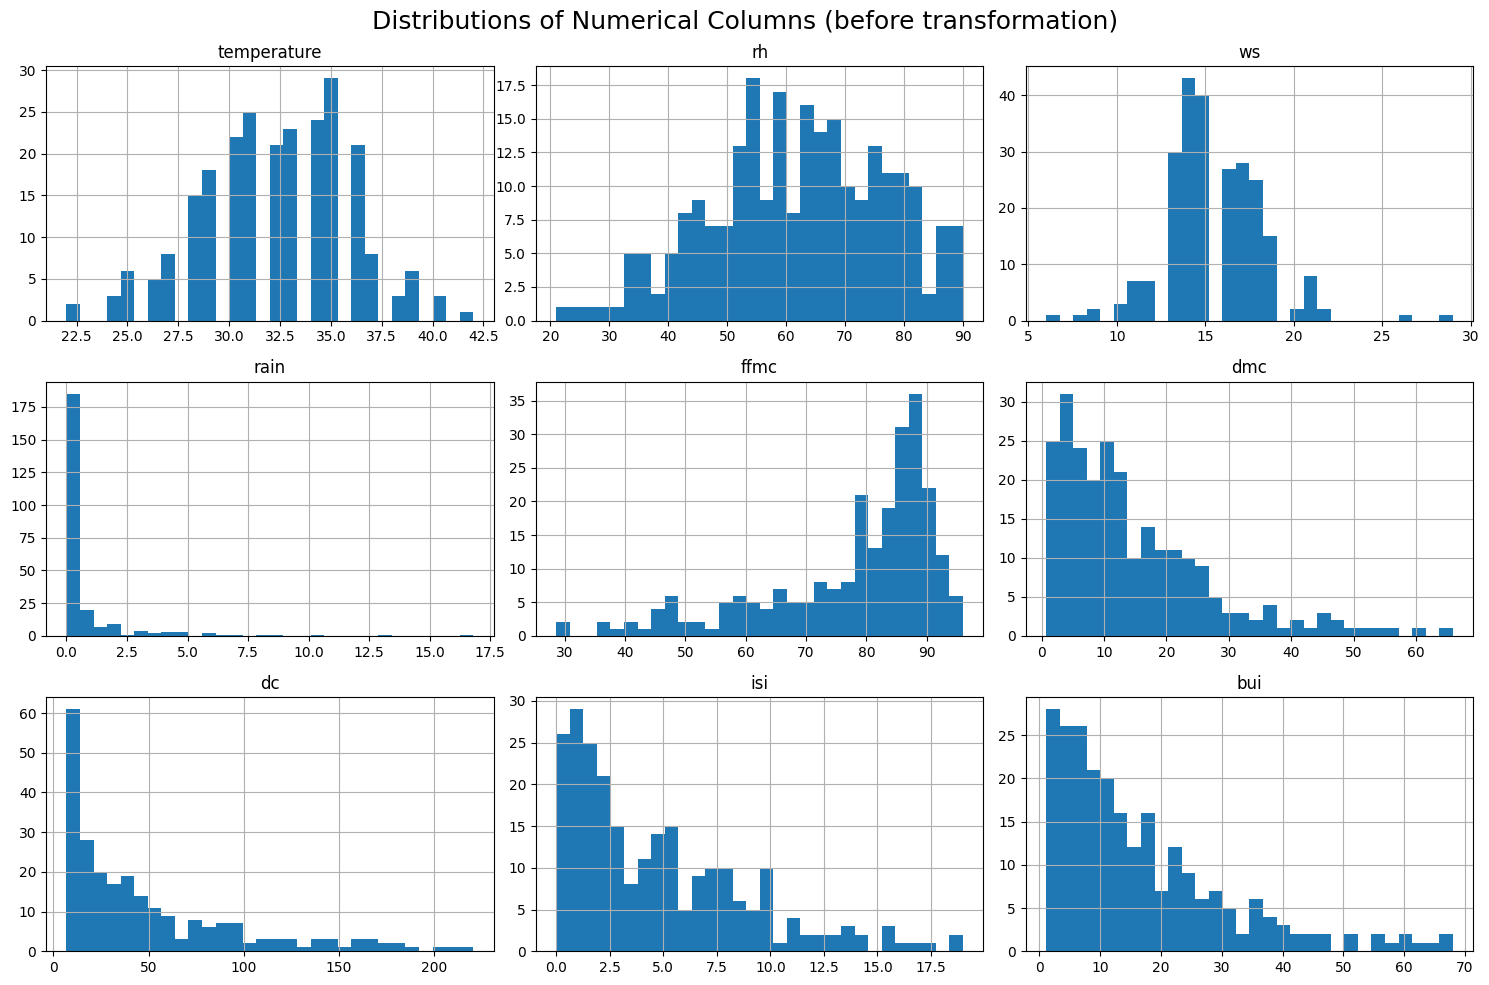

In [17]:
selected_cols = ["temperature", "rh", "ws", "rain", "ffmc", "dmc", "dc", "isi", "bui"]

df_cleaned[selected_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distributions of Numerical Columns (before transformation)", fontsize=18)
plt.tight_layout()
plt.show()

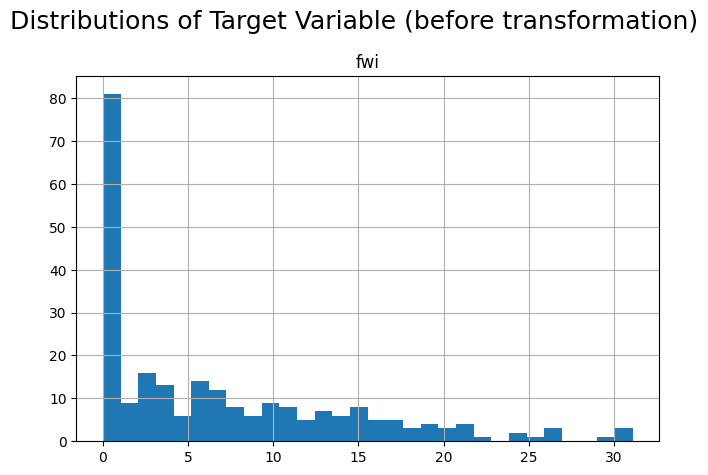

In [18]:
selected_cols = ["fwi"]

df_cleaned[selected_cols].hist(bins=30)
plt.suptitle("Distributions of Target Variable (before transformation)", fontsize=18)
plt.tight_layout()
plt.show()

**Observation**

- From the histograms, I can see that features like `temperature`, and `rh` (relative humidity) are showing normal and roughly symmetric distritubions respectively. So, I don't need any transformation on these columns.
- For `ws` (wind speed), it is slightly right-skewed. Most values are clustered between 10 to 20, with a few outliers over 20, and below 10.
- `rain` is highly right-skewed with most values are zeros, and only a few large values.
- Columns `dmc`, `dc`, `isi`, `bui` are right-skewed. I will do `log1p()` transformation on these features. 
- `ffmc` (fine fuel moisture code) is left-skewed as most values are clustered at high range from over 80.
- Finally, our target variable `fwc` is also right-skewed. I will also do `log1p()` transformtion in next step.

### Apply transformation on features and target

In [19]:
df_cleaned["rain_log"] = log1p(df_cleaned["rain"])
df_cleaned["dmc_log"] = log1p(df_cleaned["dmc"])
df_cleaned["dc_log"] = log1p(df_cleaned["dc"])
df_cleaned["isi_log"] = log1p(df_cleaned["isi"])
df_cleaned["bui_log"] = log1p(df_cleaned["bui"])

In [20]:
df_cleaned["fwi_log"] = log1p(df_cleaned["fwi"])

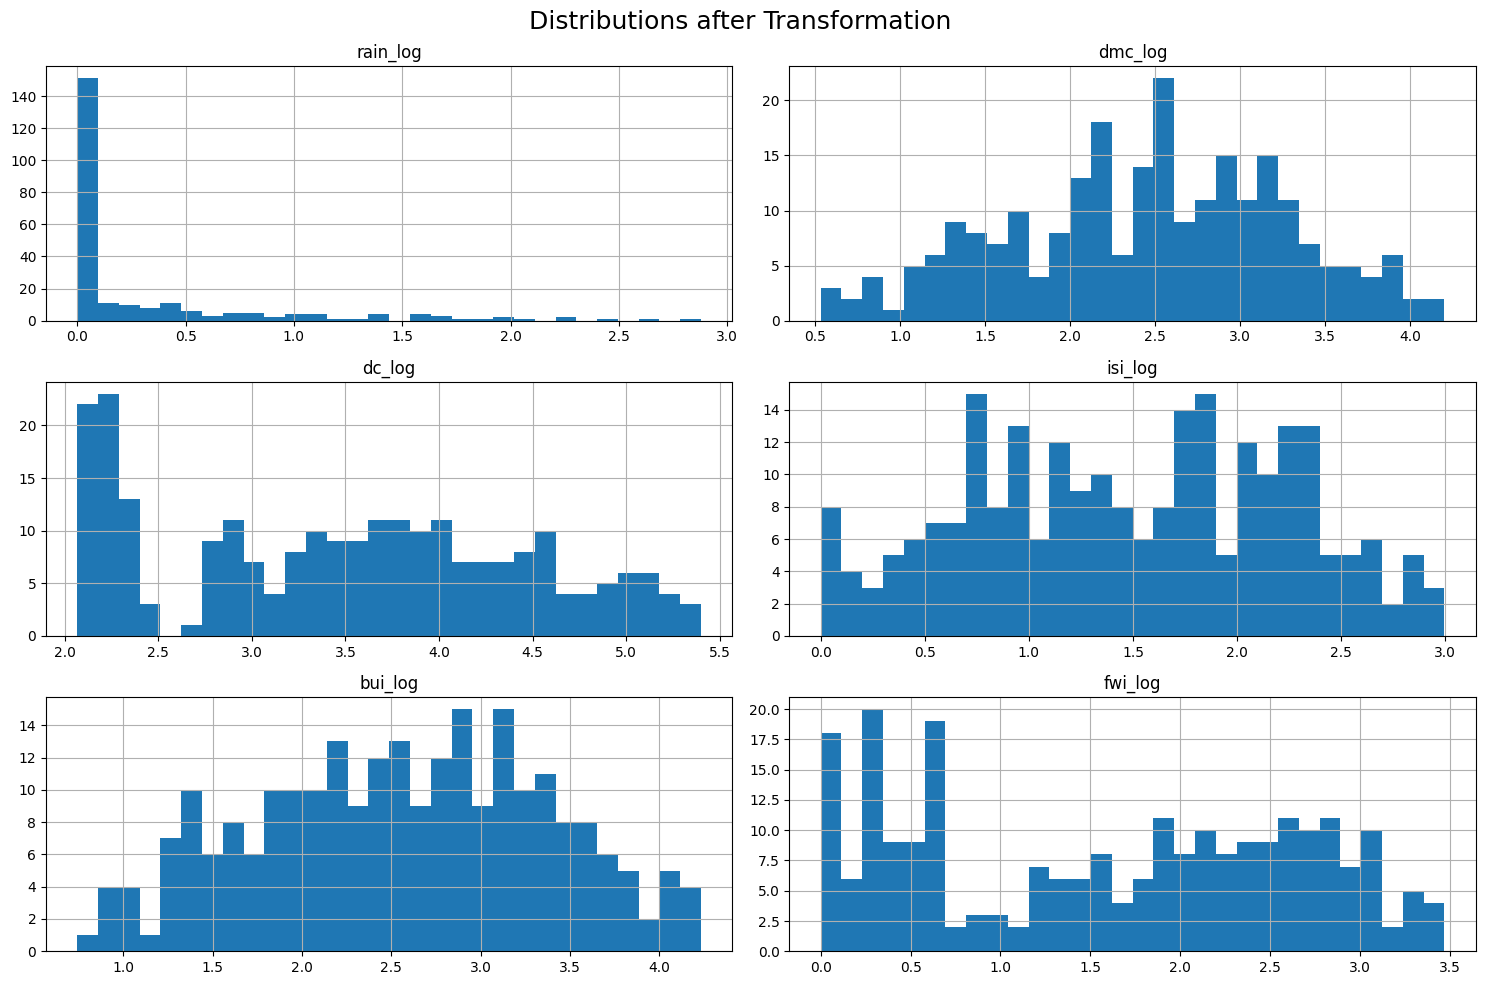

In [21]:
# Verify again
log_cols = ["rain_log", "dmc_log", "dc_log", "isi_log", "bui_log", "fwi_log"]

df_cleaned[log_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distributions after Transformation", fontsize=18)
plt.tight_layout()
plt.show()

**Observation**

Based on the transformation histograms, I can see that 
- `rain_log` is still highly right-skewed even after transformation, with most values are still around 0.0. So, I will consider doing `rain_flag` with values 0 or 1, where if a vlaue is greater than 0, it will be indicated 1.
- `dc, dmc, bui, isi, fwi` look much better after transformation. The distributions are more balanced compared to original values, so I will use the log-transformed columns for modeling. 

### Detect outliers

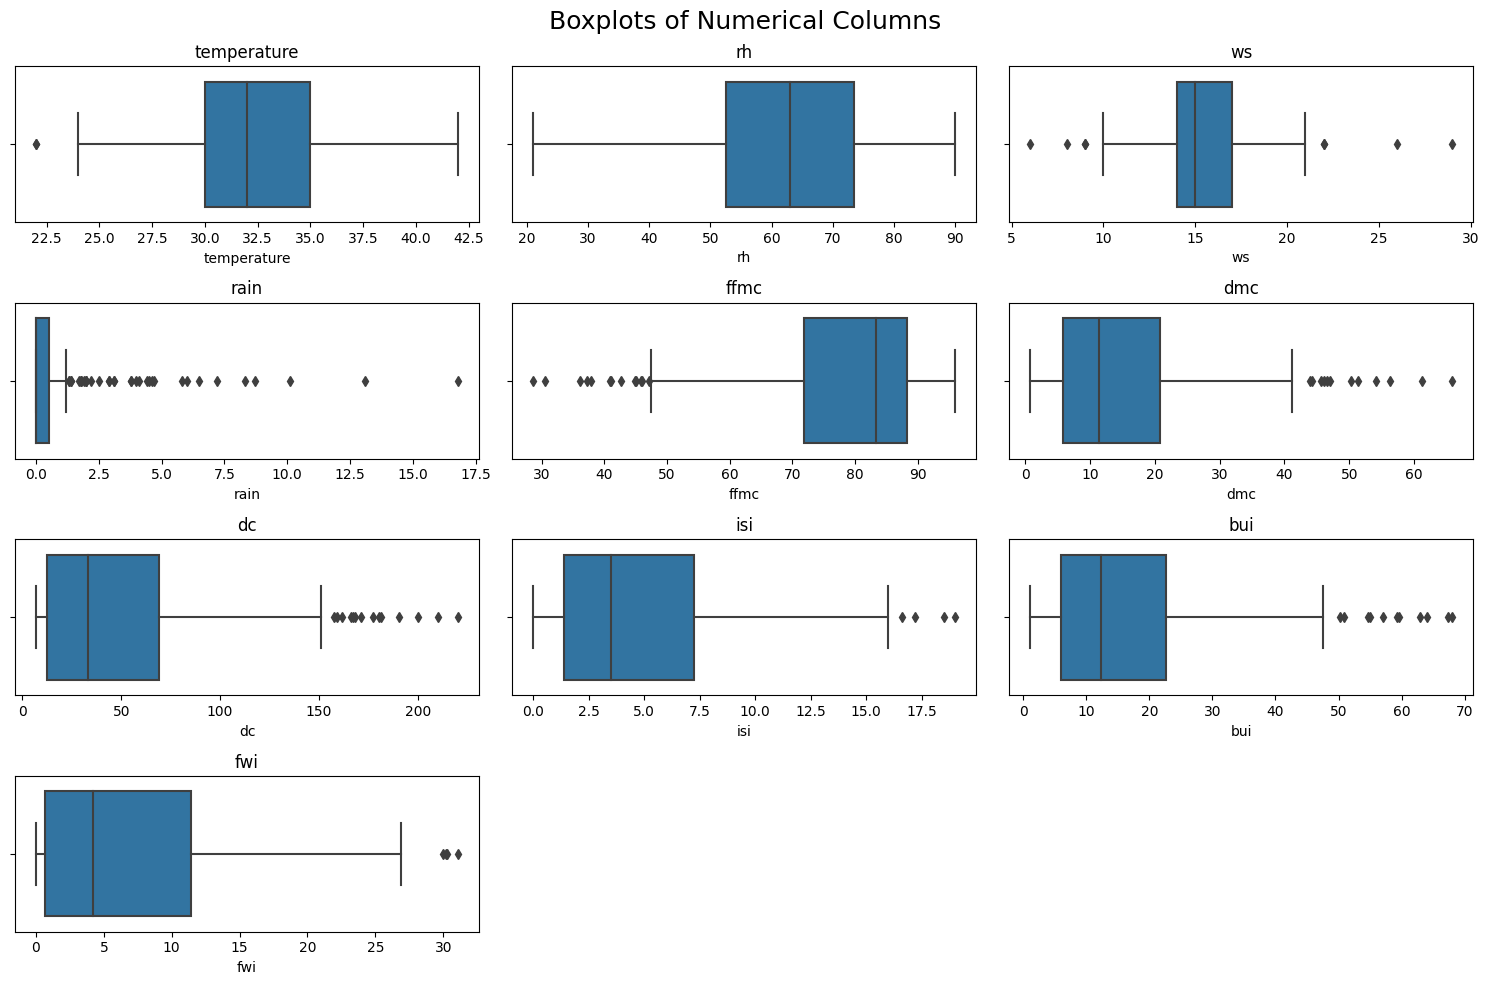

In [22]:
selected_cols = ["temperature", "rh", "ws", "rain", "ffmc", "dmc", "dc", "isi", "bui", "fwi"]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(selected_cols):
    sns.boxplot(x=df_cleaned[col], ax=axes[i])
    axes[i].set_title(col)

for j in range(i+1, len(axes)): 
    axes[j].set_visible(False) # set visible to false to hide extra plots

plt.suptitle("Boxplots of Numerical Columns", fontsize=18)
plt.tight_layout()
plt.show()

**Observation**

Based on the boxplots, 
- Features like `temperature`, `rh`, and `ws` are fairly well-distributed with few or no extreme outliers. 
- `rain` has a lot of outliers on the high end. Most values are near 0. So, rainfall over 5.0mm are quite rare.
- `dmc, dc, isi, bui` all have right-skewed patterns and they have several high-value outliers.
- Target variable `fwi` is also right-skewed, and a few high-value outliers.
- For now, I will keep the outliers since they could represent extreme weather conditions, which may be useful for predicting fire risk indicator levels. 
- I will apply **scaling** after splitting the data into training, validation, and test sets to avoid data leakage.

### Check distribution of fire cases

Fire cases (1):  137
Non-fire cases (0):  106


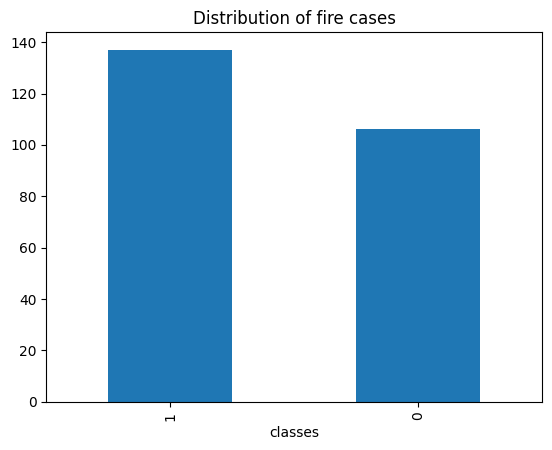

In [23]:
counts = df_cleaned['classes'].value_counts()
print("Fire cases (1): ", counts[1])
print("Non-fire cases (0): ", counts[0])

df_cleaned['classes'].value_counts().plot(kind='bar')
plt.title("Distribution of fire cases")
plt.show()

**Observation**

- Although we are predicting `FWI` in this project, the Classes column still provides useful context. It shows that fire-labeled instances are more frequent than non-fire ones. 
- There are 137 fire cases and 106 non-fire cases. However, this is a regression task, and the `classes` column is not our target variable, so I will not try to balance the dataset.

### Check correlation

In [24]:
df_cleaned.columns

Index(['day', 'month', 'temperature', 'rh', 'ws', 'rain', 'ffmc', 'dmc', 'dc',
       'isi', 'bui', 'fwi', 'classes', 'region', 'rain_log', 'dmc_log',
       'dc_log', 'isi_log', 'bui_log', 'fwi_log'],
      dtype='object')

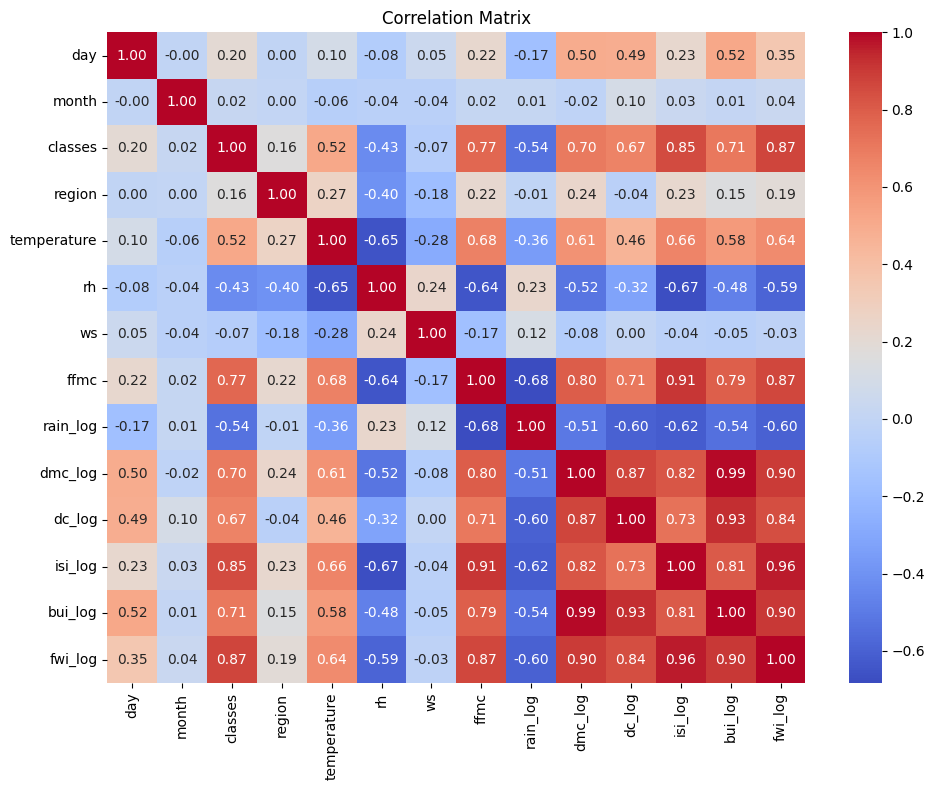

In [25]:
selected_corr_cols = [
    "day", "month", "classes", "region",
    "temperature", "rh", "ws", "ffmc",
    "rain_log", "dmc_log", "dc_log", "isi_log", "bui_log", "fwi_log"
]

corr_matrix = df_cleaned[selected_corr_cols].corr().abs() # Calculate absolute values 

plt.figure(figsize=(10,8))
sns.heatmap(df_cleaned[selected_corr_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

**Observations**

Based on the correlation matrix, 
- I can see strong correlation patterns with target variable:
    - `ffmc, dmc_log, dc_log, isi_log, bui_log` are strongly positively correlated with `fwi_log` (corr > 0.84).
    - `classes` also show high positive correlation with `fwi_log` (corr = 0.87), since it shows whether an actual fire case happened or not.
    - `temperature` has a decent correlation at 0.64.
- Meanwhile, `rh` (humidity) and `rain_log` are negatively correlated with `fwi_log` (-0.59 and -0.60). 
- Features like `day`, `month`, `region`, and `ws` don't really correlate with `fwi_log`. So, I am going to exclude them for modeling.

- The correlation matrix also shows multicollinearity between some features:
    - `dmc_log` and `bui_log` have corr 0.99. 
    - `dc_log` and `bui_log` have corr 0.93.
    - `ffmc` and `isi_log` have corr 0.91. 

**Strategy**

- Since Linear Regression is sensitive to multicollinearity, I will drop some of the highly correlated features (e.g., `dmc_log, dc_log, and bui_log`) for that baseline model.
- But for Ridge and Lasso, I will keep all features, as regularization will automatically reduce the impact of redundant ones.

### Check FWI variation with classes

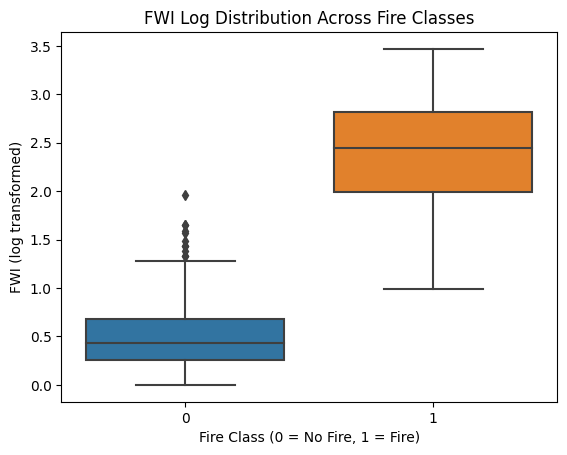

In [26]:
sns.boxplot(x='classes', y='fwi_log', data=df_cleaned)
plt.title("FWI Log Distribution Across Fire Classes")
plt.xlabel("Fire Class (0 = No Fire, 1 = Fire)")
plt.ylabel("FWI (log transformed)")
plt.show()

**Observation**

- From the boxplot, it is clear that `fwi_log` values are much higher for classes=1 (fire) compared to classes-0.
- This confirms the observation I made earlier where classes are highly positive correlated with `fwi_log`.

### Drop irrelevant and raw features

In [27]:
irrelevant_columns = ["day", "month", "region", "ws"]
raw_columns = ["rain", "dmc", "dc", "isi", "bui", "fwi"]

cols_to_drop = irrelevant_columns + raw_columns
print("Columns to drop:", cols_to_drop)

Columns to drop: ['day', 'month', 'region', 'ws', 'rain', 'dmc', 'dc', 'isi', 'bui', 'fwi']


In [28]:
df_cleaned = df_cleaned.drop(cols_to_drop, axis=1)
print(df_cleaned.columns)

Index(['temperature', 'rh', 'ffmc', 'classes', 'rain_log', 'dmc_log', 'dc_log',
       'isi_log', 'bui_log', 'fwi_log'],
      dtype='object')


### Drop highly correlated features (for LR)

In [29]:
upper_tri = corr_matrix.mask(np.tril(np.ones(corr_matrix.shape)).astype(bool))

cols_to_drop = [column for column in upper_tri.columns 
                if column != "fwi_log" and any(upper_tri[column] > 0.90)]

print("Columns to drop due to high correlation: ", cols_to_drop)

Columns to drop due to high correlation:  ['isi_log', 'bui_log']


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


### Create separate dataframes for LR and Regularized models

In [30]:
# Create a df for LR model
df_regression = df_cleaned.copy()

df_regression = df_regression.drop(columns=cols_to_drop)

print(df_regression.columns)
print(df_regression.isnull().sum())

Index(['temperature', 'rh', 'ffmc', 'classes', 'rain_log', 'dmc_log', 'dc_log',
       'fwi_log'],
      dtype='object')
temperature    0
rh             0
ffmc           0
classes        0
rain_log       0
dmc_log        0
dc_log         0
fwi_log        0
dtype: int64


In [31]:
# Create a df for regularized models
df_regularized = df_cleaned.copy()

print(df_regularized.columns)
print(df_regularized.isnull().sum())

Index(['temperature', 'rh', 'ffmc', 'classes', 'rain_log', 'dmc_log', 'dc_log',
       'isi_log', 'bui_log', 'fwi_log'],
      dtype='object')
temperature    0
rh             0
ffmc           0
classes        0
rain_log       0
dmc_log        0
dc_log         0
isi_log        0
bui_log        0
fwi_log        0
dtype: int64


## 3. Model Development and Analysis

**Approach**

- Now that we have two separate dataframes, I will train models accordingly using:
    - df_regression for baseline Linear Regression model
    - df_regularized for Ridge and Lasso

- For Linear Regression, I will:
    - Split into training and test sets.
    - Initialize and fit LinearRegression model as baseline.
    - Use `StandardScaler()` to scale the features. But it is fitted only on the training set, then applied to both train and test sets to avoid data leakage.

- For Ridge and Lasso, I will:
    - Initialize Ridge and Lasso models.
    - Fit both on the same split for comparison.
    - Use `RidgeCV` and `LassoCV` for baseline cross-validation, and quick alpha tuning.
    - Additionally, apply `GridSearchCV` to tune multiple parameters.
    
- I will keep the test set to use later in Section 4 for evaluations and comparison across models.

### Split into training and test

In [32]:
# Separate features and target
X_reg = df_regression.drop(columns="fwi_log")
y_reg = df_regression["fwi_log"]

# Split into training and test sets (80-20)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("Train size:", X_train_reg.shape)
print("Test size:", X_test_reg.shape)

Train size: (194, 7)
Test size: (49, 7)


### Scale the features

In [33]:
scaler = StandardScaler()

X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

### Initialize and fit LinearRegression model

In [34]:
lr_model = LinearRegression()

lr_model.fit(X_train_reg_scaled, y_train_reg)

LinearRegression()

### Split df_regularized into training and test

In [35]:
# Separate features and target
X_ridge_lasso = df_regularized.drop(columns=["fwi_log"])
y_ridge_lasso = df_regularized["fwi_log"]

# Split into training and test sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_ridge_lasso, y_ridge_lasso, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (194, 9)
Test size: (49, 9)


### Scale the features

In [36]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Initialize and fit Regularized Regression Models (Ridge and Lasso)

In [37]:
# Define parameter grid for alpha
alphas = np.logspace(-3, 3, 100)

# Intialize Ridge Regression with Cross-Validation, and fit to training
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

# Initialize Lasso with Cross-Validation, and fit to training
lasso_cv = LassoCV(cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

LassoCV(cv=5, max_iter=10000)

In [38]:
print(f"Best alpha (Ridge): {ridge_cv.alpha_:.4f}")
print(f"Best alpha (Lasso): {lasso_cv.alpha_:.4f}")

Best alpha (Ridge): 0.4037
Best alpha (Lasso): 0.0017


### Apply hyperparameter tuning using GridSearchCV

In [39]:
# Define parameter grid for Ridge
param_grid_ridge = {
    'alpha': np.logspace(-3, 3, 50),
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

# Initialize and fit GridSearchCV for Ridge
ridge_gs = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid_ridge,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)
ridge_gs.fit(X_train_scaled, y_train)

# Get the best model
best_ridge = ridge_gs.best_estimator_
print(f"Best Ridge Params: {ridge_gs.best_params_}")

Best Ridge Params: {'alpha': 0.022229964825261943, 'fit_intercept': True, 'solver': 'lsqr'}


In [40]:
# Define parameter grid for Lasso
param_grid_lasso = {
    'alpha': np.logspace(-3, 3, 50),
    'fit_intercept': [True, False],
    'selection': ['cyclic', 'random'],
    'max_iter': [1000, 5000, 10000]
}

# Initialize and fit GridSearchCV for Lasso
lasso_gs = GridSearchCV(
    estimator=Lasso(),
    param_grid=param_grid_lasso,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)
lasso_gs.fit(X_train_scaled, y_train)

# Get the best model
best_lasso = lasso_gs.best_estimator_
print(f"Best Lasso Params: {lasso_gs.best_params_}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.129e+01, tolerance: 5.838e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e+00, tolerance: 5.710e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.379e+01, tolerance: 6.146e

Best Lasso Params: {'alpha': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'selection': 'cyclic'}


**Observation**

- I used `RidgeCV` and `LassoCV` for quick and efficient alpha tuning with built-in 5-fold cross-validation.
- Then, I used `GridSearchCV` to tune additional parameters:
    - For Ridge, I tuned fit_intercept, solver
    - For Lasso, I tuned selection and max_iter
- Since, GridSearchCV always tries to maximize the score, not minimize. And MAE, MSE, RMSE are all loss functions, so the lower value is the better. That's why we used `neg_mean_absolute_error` as the scoring metric for this hyperparameter tuning.
- Now that I have the tuned models, I will evaluate them and compare the results against the Linear Regression baseline.

## 4. Model Evaluation and Testing

**Approach**

- As I have learnt in the class,
    - If there are too many outliers in the target variable, it's standard practice to prefer `MAE` over `RMSE`. That’s because `RMSE` heavily penalizes large errors because it squares them, so a few extreme values can distort the overall error metric. 
    - On the other hand, `MAE` is more stable as it treats all errors equally, and gives a clearer picture when the target isn't perfectly normal.

- In this project, I already standardized all features, and the target variable has also been scaled. So outliers on the input side shouldn’t affect model training that much. So, outliers won’t mess up model training as much. But, the outliers are still there in the dataset, since I just scaled them instead of removing them. 

- So I will still include `MAE` alongside `RMSE` and `R²` for model evaluations. 

### Evaluate on test data

In [41]:
# Predict using baseline Linear Regression
y_pred_lr = lr_model.predict(X_test_reg_scaled)
mae_lr = mean_absolute_error(y_test_reg, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test_reg, y_pred_lr))
r2_lr = r2_score(y_test_reg, y_pred_lr)

In [42]:
# Predict using RidgeCV (initial CV-based model)
y_pred_ridge = ridge_cv.predict(X_test_scaled)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

In [43]:
# Predict using LassoCV (initial CV-based model)
y_pred_lasso = lasso_cv.predict(X_test_scaled)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

In [44]:
# Predict tuned Ridge from GridSearchCV
y_pred_ridge_gs = best_ridge.predict(X_test_scaled)
mae_ridge_gs = mean_absolute_error(y_test, y_pred_ridge_gs)
rmse_ridge_gs = np.sqrt(mean_squared_error(y_test, y_pred_ridge_gs))
r2_ridge_gs = r2_score(y_test, y_pred_ridge_gs)

In [45]:
# Predict tuned Lasso from GridSearchCV
y_pred_lasso_gs = best_lasso.predict(X_test_scaled)
mae_lasso_gs = mean_absolute_error(y_test, y_pred_lasso_gs)
rmse_lasso_gs = np.sqrt(mean_squared_error(y_test, y_pred_lasso_gs))
r2_lasso_gs = r2_score(y_test, y_pred_lasso_gs)

In [46]:
results_df = pd.DataFrame({
    "Model": ["Linear Regression", "RidgeCV", "LassoCV", "Tuned Ridge (GS)", "Tuned Lasso (GS)"],
    "MAE": [mae_lr, mae_ridge, mae_lasso, mae_ridge_gs, mae_lasso_gs],
    "RMSE": [rmse_lr, rmse_ridge, rmse_lasso, rmse_ridge_gs, rmse_lasso_gs],
    "R²": [r2_lr, r2_ridge, r2_lasso, r2_ridge_gs, r2_lasso_gs]
})

print("Model Evaluation Results (Test Set):")
print(results_df.round(4))

Model Evaluation Results (Test Set):
               Model     MAE    RMSE      R²
0  Linear Regression  0.2004  0.2754  0.9139
1            RidgeCV  0.0806  0.1157  0.9848
2            LassoCV  0.0810  0.1175  0.9843
3   Tuned Ridge (GS)  0.0794  0.1144  0.9851
4   Tuned Lasso (GS)  0.0801  0.1158  0.9848


**Analysis**

Based on the metrics, I can analyse that:
- Bseline Linear Regression gave the worst performance compared to other models, with MAE = 0.2004, RMSE = 0.2754, and R-squared = 0.9139.
- RidgeCV and LassoCV models, where we only tuned alpha, and used built-in cross-validation, gave a better performance compared to LR.
- The best performing model is `Tuned Ridge` using GridSearchCV. It has
    - Lowest MAE (0.0794) and lowest RMSE (0.1144)
    - Highest R-square (0.9851), meaning that the model explains 98.51% of the variance in `fwi_log`
- Compared to that, `Tuned Lasso (GS)` also improved over `LassoCV` with MAE = 0.0805, RMSE = 0.1164 and R-square = 0.9846. This is the second best performing model. 
- Next, I will save the best_ridge as the final model and save the pickle file. 

### Save best modle as pickle file

In [47]:
final_model = best_ridge

os.makedirs("../models", exist_ok=True)

with open("../models/final_model.pkl", "wb") as f:
    pickle.dump(best_ridge, f)

## Key Takeways

* This project covered everything end-to-end, from cleaning the dataset, doing feature transformations, exploring distributions and outliers, checking correlation, and building multiple regression models.
* I had to work with skewed features and outliers, and instead of dropping them, I used log transformation and standardization. I also removed some features based on correlation thresholds to reduce multicollinearity.
* For modeling, I compared plain Linear Regression vs. Ridge and Lasso, using both the CV-based and fully tuned versions. I learned when it makes sense to use RidgeCV / LassoCV vs. GridSearchCV, depending on how much control I need over hyperparameters.
* Evaluation was done using MAE, RMSE, and R². Since the target has some outliers and I didn't remove any outliers, I made sure to include MAE for robustness, not just rely on RMSE.
* The best performing model was the tuned Ridge using GridSearchCV, and I saved it using pickle for future use.
* Overall, this project solidified my understanding of regression modeling, and what we studied throughtout the course, and I’m now better prepared to tackle similar problems in future projects.